## Import Libraries

In [1]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import ydata_profiling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics


## Load the Data

In [2]:
df = pd.read_csv("final_data.csv")

In [3]:
df.shape

(10754, 22)

In [4]:
df.head(2)

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.0,32.0,104,0.0,0.0,0.009585,...,1.217252,0.335463,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.0,30.0,15,0.0,0.0,0.069018,...,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [5]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [6]:
# Completeness
df.isnull().sum()

player                 0
team                   0
name                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
position_encoded       0
winger                 0
dtype: int64

In [7]:
# Accurecy types
df.dtypes

player                  object
team                    object
name                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
position_encoded         int64
winger                   int64
dtype: object

In [8]:
df.drop('player', axis=1, inplace=True)
df.drop('name', axis=1, inplace=True)
df.drop('goals conceded', axis=1, inplace=True)
df.drop('clean sheets', axis=1, inplace=True)

In [9]:
# Convert categorical variables using OneHotEncoding
categorical_features = ['team', 'position']
numeric_features = ['height', 'age', 'appearance', 'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards', 'goals conceded', 'minutes played', 'games_injured', 'award', 'current_value', 'highest_value', 'position_encoded', 'winger']

In [10]:
# Calculate the frequency of each 'team'
type_counts = df['team'].value_counts()
# Filter 'team' values that appear 10 or more times
df = df[df['team'].isin(type_counts[type_counts >= 20].index)]

In [11]:
df.shape

(10736, 18)

In [12]:
# Calculate the frequency of each 'position'
position_counts = df['position'].value_counts()
# Filter 'position' values that appear 10 or more times
df = df[df['position'].isin(position_counts[position_counts >=30].index)]

In [13]:
df.shape

(10736, 18)

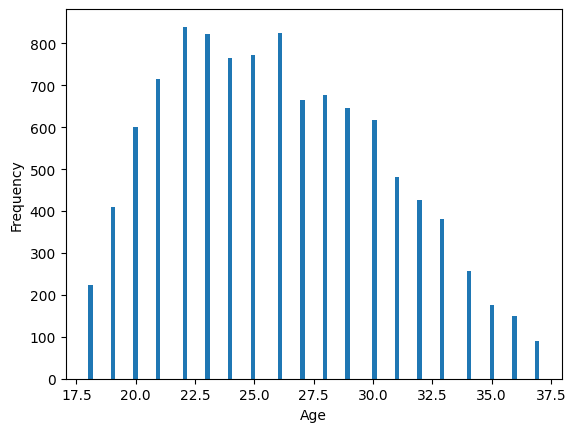

In [14]:
df = df[df['age']>=18]
df = df[df['age']<=37]
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.hist(df['age'], bins=100)
plt.show()

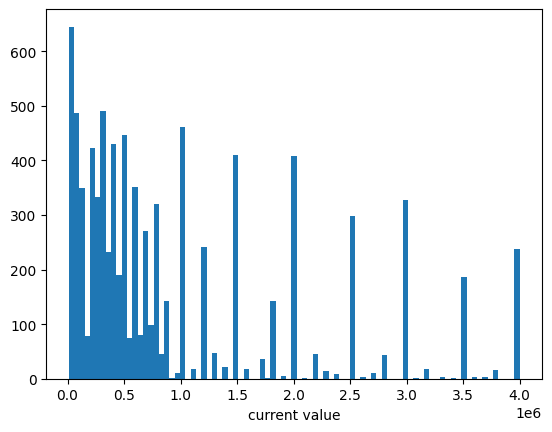

In [15]:
df = df[df['current_value'] > 2000]
df = df[df['current_value'] <= 4000000]
plt.xlabel('current value')
plt.hist(df['current_value'], bins= 85)
plt.show()

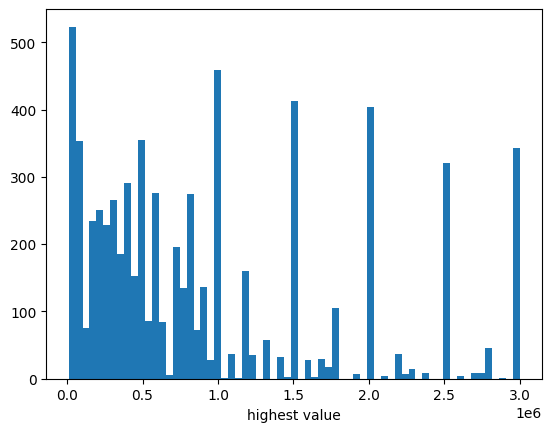

In [16]:
df = df[df['highest_value'] > 2000]
df = df[df['highest_value'] <= 3000000]
plt.xlabel('highest value')
plt.hist(df['highest_value'], bins= 65)
plt.show()

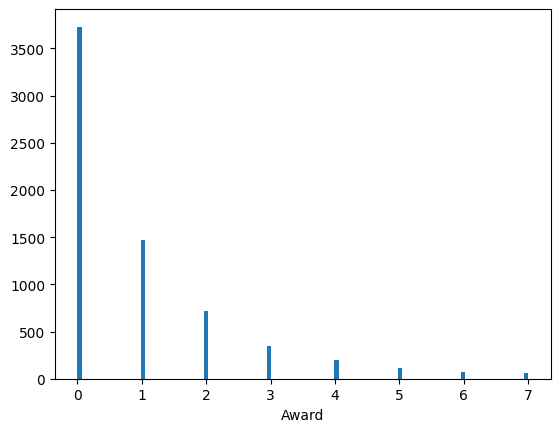

In [17]:
df = df[df['award'] <= 7]
plt.hist(df['award'], bins=100)
plt.xlabel('Award')
plt.show()

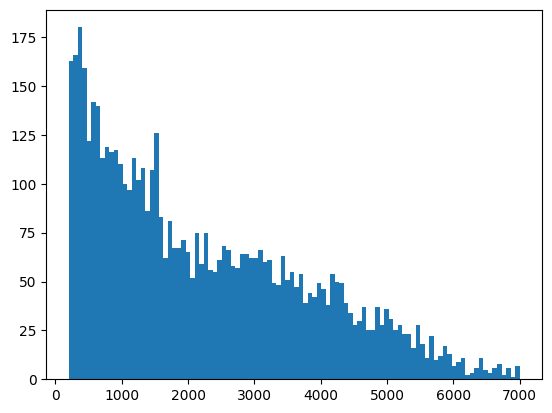

In [18]:
df= df[df['minutes played'] >= 200 ]
df= df[df['minutes played'] <= 7000]
plt.hist(df['minutes played'], bins=100)
plt.show()

In [19]:
df.shape

(5564, 18)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [20]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
8,Manchester United,Defender Centre-Back,186.0,21.0,34,0.000000,0.000000,0.130529,0.0,0.0,2758,47,13,0,2000000,2000000,2,0
20,Manchester United,midfield-CentralMidfield,181.0,20.0,39,0.129125,0.064562,0.225968,0.0,0.0,2788,0,0,1,800000,800000,3,0


In [21]:
categorical_features

['team', 'position']

In [22]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [23]:
df.shape

(5564, 392)

In [24]:
df.head(2)

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,minutes played,days_injured,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
8,186.0,21.0,34,0.000000,0.000000,0.130529,0.0,0.0,2758,47,...,True,False,False,False,False,False,False,False,False,False
20,181.0,20.0,39,0.129125,0.064562,0.225968,0.0,0.0,2788,0,...,False,False,False,False,False,False,True,False,False,False


In [25]:

# Calculate the 25th and 85th percentiles of 'current_value'
p25 = df['current_value'].quantile(0.25)
p85 = df['current_value'].quantile(0.85)

# Function to categorize 'current_value' based on percentiles
def categorize_current_value(current_value):
    if current_value < p25:
        return 'Cheap'
    elif current_value < p85:
        return 'Moderate'
    else:
        return 'Expensive'

# Apply the function to create a new column 'current_value_category'
df['current_value_category'] = df['current_value'].apply(categorize_current_value)

# Optionally, drop the original 'current_value' column
df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['current_value_category'].value_counts())

current_value_category
Moderate     3343
Cheap        1261
Expensive     960
Name: count, dtype: int64


In [26]:
p25, p85

(250000.0, 1500000.0)

In [27]:
encoder = LabelEncoder()
df['current_value_category_encoded'] = encoder.fit_transform(df['current_value_category'])  

#### 3. Feature selection

In [28]:
correlation = df.corr(numeric_only=True)
print(correlation['current_value_category_encoded'].sort_values(ascending=False))

current_value_category_encoded    1.000000
appearance                        0.192290
minutes played                    0.172608
highest_value                     0.161990
award                             0.138089
                                    ...   
team_Chippa United               -0.074984
team_Royal AM FC                 -0.079892
position_Attack                  -0.080207
position_midfield                -0.087875
position_Goalkeeper              -0.123645
Name: current_value_category_encoded, Length: 392, dtype: float64


In [29]:
# Set the correlation threshold
threshold = 0.09 # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value_category_encoded']) > \
threshold]['current_value_category_encoded'].index
selected_features

Index(['age', 'appearance', 'assists', 'minutes played', 'days_injured',
       'games_injured', 'award', 'highest_value', 'position_Goalkeeper',
       'current_value_category_encoded'],
      dtype='object')

In [55]:
selected_features = ['age', 'appearance', 'assists', 'minutes played', 'days_injured',
       'games_injured', 'award', 'highest_value', 'current_value_category_encoded']

In [56]:
df = df[selected_features]
df.head()

,age,appearance,assists,minutes played,days_injured,games_injured,award,highest_value,current_value_category_encoded
8,21.0,34,0.000000,2758,47,13,0,2000000,1
20,20.0,39,0.064562,2788,0,0,1,800000,2
21,18.0,51,0.102506,3512,0,0,1,800000,2
55,25.0,65,0.000000,5867,0,0,0,2000000,1
83,30.0,8,0.000000,644,718,84,1,2000000,2


#### 4. Prepare train and test data

In [57]:
# Prepare data
X = df.drop(['current_value_category_encoded'], axis=1)
y = df['current_value_category_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [58]:
X.shape

(5564, 8)

## Buliding the Model

In [59]:
model = KNeighborsClassifier()

In [60]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10]
}
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

## Train the Model

In [61]:
# Fit the model on the training data
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='f1_macro', verbose=1)

In [62]:
grid_search.best_params_

{'n_neighbors': 10}

In [63]:
model = grid_search.best_estimator_

## Test the Model

In [64]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

## Evaluating the Model 

In [65]:
# our benchmark model
base_model = round(df['current_value_category_encoded'].value_counts()[1]/df.shape[0]*100, 2)
base_model

17.25

1. Accuracy

In [66]:
# Train score
y_pred_train = model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

0.8434059761851269

In [67]:
# Test score
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8158131176999102

In [68]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[167,   1,  67],
       [  0, 162,  50],
       [ 52,  35, 579]], dtype=int64)

In [69]:
print("Train classification report for best knn:")
print(f' {classification_report(y_train, y_pred_train, labels=list(model.classes_))}')
print("Test classification report for best knn: ")
print(f'{classification_report(y_test, y_pred, labels=list(model.classes_))}')

Train classification report for best knn:
               precision    recall  f1-score   support

           0       0.82      0.74      0.77      1026
           1       0.82      0.84      0.83       748
           2       0.86      0.89      0.87      2677

    accuracy                           0.84      4451
   macro avg       0.83      0.82      0.83      4451
weighted avg       0.84      0.84      0.84      4451

Test classification report for best knn: 
              precision    recall  f1-score   support

           0       0.76      0.71      0.74       235
           1       0.82      0.76      0.79       212
           2       0.83      0.87      0.85       666

    accuracy                           0.82      1113
   macro avg       0.80      0.78      0.79      1113
weighted avg       0.81      0.82      0.81      1113



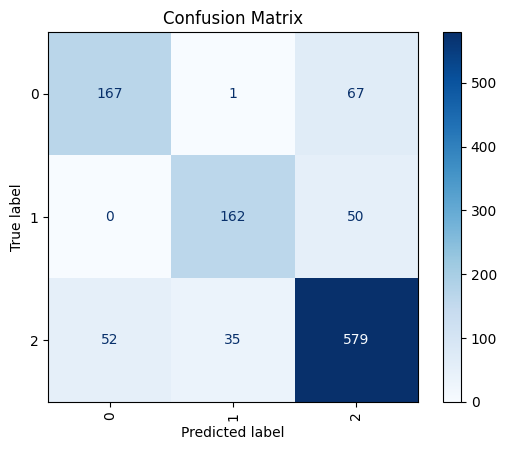

In [70]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [71]:
# Calculate Precision
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.80


In [72]:
# Calculate Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.78


In [73]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.79


In [74]:
# Check the number of features expected by the model
print("Number of features expected by the model:", model.n_features_in_)

Number of features expected by the model: 8


In [75]:
# Check if the scaler object has the feature names attribute
if hasattr(scaler, "feature_names_in_"):
    print("Feature names used for training:", scaler.feature_names_in_)

Feature names used for training: ['age' 'appearance' 'assists' 'minutes played' 'days_injured'
 'games_injured' 'award' 'highest_value']


In [76]:
import joblib

# Save the model and scaler using joblib
joblib.dump(model, 'knn_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']